In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

import utils

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
plt.rcParams.update({"font.size": 20})

In [3]:
! ls ../Feb9_2017

GluGluHToWW_Pt-200ToInf_M-125 TTToSemiLeptonic
QCD_Pt_1800to2400


# Read parquets
- loads parquet dataframes and combine different pt-bins per sample
- applies a specified preselection
- saves the combined dataframe under `events[ch][sample]`

In [8]:
year = "2017"
channels = ["mu", "ele"]

samples_dir = "../Feb9_2017"
samples = os.listdir(samples_dir)

combine_samples = {
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    
    # bkg
    "QCD_Pt": "QCD",
    "TT": "TTbar",
}

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
}

In [10]:
def apply_selection(presel): 
    events_dict = {}
    for ch in channels:
        events_dict[ch] = {}

        # get lumi
        with open("../fileset/luminosity.json") as f:
            luminosity = json.load(f)[ch]["2017"]

        for sample in samples:

            ### get a combined label to combine samples of the same process
            for key in combine_samples:
                if key in sample:
                    sample_to_use = combine_samples[key]
                    break
                else:
                    sample_to_use = sample

            is_data = False
            if sample_to_use == data_by_ch[ch]:
                is_data = True         

            print(f"Finding {sample} samples and should combine them under {sample_to_use}")

            out_files = f"{samples_dir}/{sample}/outfiles/"
            parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
            pkl_files = glob.glob(f"{out_files}/*.pkl")

            if not parquet_files:
                print(f"No parquet file for {sample}")
                continue                

            data = pd.read_parquet(parquet_files)
            empty = len(data) == 0
            if empty:
                continue

            # apply selection
            print("---> Applying preselection.")
            for selection in presel[ch]:
                print(f"applying {selection} selection on {len(data)} events")
                data = data.query(presel[ch][selection])  
            print("---> Done with preselection.")

            # get event_weight
            if not is_data:       
                print("---> Accumulating event weights.")                
                event_weight = utils.get_xsecweight(pkl_files, "2017", sample, is_data, luminosity)
                for w in weights[ch]:
                    if w not in data.keys():
                        print(f"{w} weight is not stored in parquet")
                        continue
                    event_weight *= data[w]
                print("---> Done with accumulating event weights.")                       
            else:
                event_weight = np.ones_like(data["fj_pt"])

            data["event_weight"] = event_weight

            print(f"Will fill the {sample_to_use} dataframe with the remaining {len(data)} events")
            print(f"tot event weight {data['event_weight'].sum()} \n")

            # fill the big dataframe
            if sample_to_use not in events_dict[ch].keys():
                events_dict[ch][sample_to_use] = data
            else:
                events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])
    return events_dict

In [12]:
presel = {
    "mu": {
        # normal preselection
        "leptonKin": "(lep_pt > 30)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",   
        "isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",

    },
    "ele": {
        # normal preselection        
        "leptonKin": "(lep_pt > 40)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",
        "isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",  
    }
}

events_dict_after_preselection = apply_selection(presel)

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Applying preselection.
applying leptonKin selection on 24213 events
applying fatjetKin selection on 21460 events
applying ht selection on 4093 events
applying oneLepton selection on 4093 events
applying notaus selection on 3876 events
applying leptonInJet selection on 2800 events
applying metfilters selection on 874 events
applying isolation selection on 874 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 849 events
tot event weight 87586.60242654714 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Applying preselection.
applying leptonKin selection on 69358 events
applying fatjetKin selection on 63747 events
applying ht selection on 51946 events
applying oneLepton selection on 51899 events
applying notaus select

<ipython-input-10-f6ae1cd2ecae>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight
<ipython-input-10-f6ae1cd2ecae>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight


applying metfilters selection on 14916 events
applying isolation selection on 14901 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the HWW dataframe with the remaining 14439 events
tot event weight 117.63907849028585 

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
applying leptonKin selection on 106281 events
applying fatjetKin selection on 12217 events
applying ht selection on 12208 events
applying oneLepton selection on 12208 events
applying notaus selection on 11021 events
applying leptonInJet selection on 9630 events
applying metfilters selection on 2902 events
applying isolation selection on 2848 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 2

<ipython-input-10-f6ae1cd2ecae>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight
<ipython-input-10-f6ae1cd2ecae>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight


In [11]:
presel = {
    "mu": {
        "trivial": "(fj_pt > 0)", 
    },
    "ele": {
        "trivial": "(fj_pt > 0)", 
    }
}

events_dict_before_preselection = apply_selection(presel)

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Applying preselection.
applying trivial selection on 24213 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 4093 events
tot event weight 446315.2876039576 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Applying preselection.
applying trivial selection on 69358 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the HWW dataframe with the remaining 51946 events
tot event weight 427.49928473659725 

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
applying trivial selection on 106281 events
---> Done with preselection.
---> Accumulating event weig

<ipython-input-10-f6ae1cd2ecae>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight
<ipython-input-10-f6ae1cd2ecae>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["event_weight"] = event_weight
<ipython-input-10-f6ae1cd2ecae>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

## PKU vs UCSD

In [16]:
nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

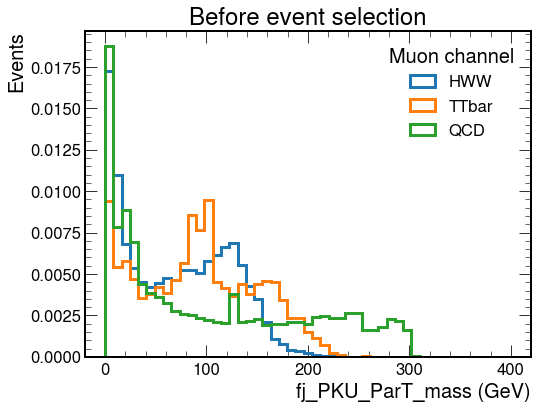

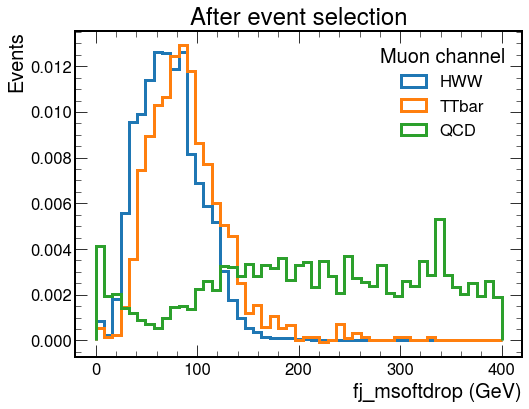

In [18]:
plt.rcParams.update({"font.size": 20})
samples_to_plot = ["HWW", "TTbar", "QCD"]

ch = "mu"

### regressed mass
fig, ax = plt.subplots(figsize=(8, 6))
bins_ = np.linspace(0,400)
for sample in samples_to_plot:
    ax.hist(
        events_dict_before_preselection[ch][sample]["fj_PKU_ParT_mass"].values,
        bins_,
        label=sample,
        linewidth=3,
        density=True,
        histtype="step",
        weights=events_dict_before_preselection[ch][sample]["event_weight"].values
    )    
xch = nice_channel[ch]    
ax.legend(title=f"{xch} channel")
ax.set_ylabel("Events")
ax.set_xlabel("fj_PKU_ParT_mass (GeV)")
ax.set_title("Before event selection");

fig, ax = plt.subplots(figsize=(8, 6))
bins_ = np.linspace(0,400)
for sample in samples_to_plot:
    ax.hist(
        events_dict_after_preselection[ch][sample]["fj_msoftdrop"].values,
        bins_,
        label=sample,
        linewidth=3,
        density=True,
        histtype="step",
        weights=events_dict_after_preselection[ch][sample]["event_weight"].values
    )    
xch = nice_channel[ch]
ax.legend(title=f"{xch} channel")
ax.set_ylabel("Events")
ax.set_xlabel("fj_msoftdrop (GeV)")
ax.set_title("After event selection");

In [19]:
# for direct comparisons, these must be overlooked
labels_to_be_removed = ['fj_ParT_probQCD', 'fj_ParT_probTopb', 'fj_ParT_probHWWelenuqq', 'fj_ParT_probHWWmunuqq']

UCSD_labels, PKU_labels = [], []    

for key in events_dict["mu"]["HWW"].keys():   # any sample will do
    if "prob" in key:      
        if "PKU" in key:
            PKU_labels.append(key)        
        elif ("ParT" in key):
            if key not in labels_to_be_removed:
                UCSD_labels.append(key)              

In [20]:
PKU_labels

['fj_PKU_ParT_probHWqqWqq0c',
 'fj_PKU_ParT_probHWqqWqq1c',
 'fj_PKU_ParT_probHWqqWqq2c',
 'fj_PKU_ParT_probHWqqWq0c',
 'fj_PKU_ParT_probHWqqWq1c',
 'fj_PKU_ParT_probHWqqWq2c',
 'fj_PKU_ParT_probHWqqWev0c',
 'fj_PKU_ParT_probHWqqWev1c',
 'fj_PKU_ParT_probHWqqWmv0c',
 'fj_PKU_ParT_probHWqqWmv1c',
 'fj_PKU_ParT_probHWqqWtauev0c',
 'fj_PKU_ParT_probHWqqWtauev1c',
 'fj_PKU_ParT_probHWqqWtaumv0c',
 'fj_PKU_ParT_probHWqqWtaumv1c',
 'fj_PKU_ParT_probHWqqWtauhv0c',
 'fj_PKU_ParT_probHWqqWtauhv1c',
 'fj_PKU_ParT_probHbb',
 'fj_PKU_ParT_probHcc',
 'fj_PKU_ParT_probHss',
 'fj_PKU_ParT_probHqq',
 'fj_PKU_ParT_probHtauhtaue',
 'fj_PKU_ParT_probHtauhtaum',
 'fj_PKU_ParT_probHtauhtauh',
 'fj_PKU_ParT_probQCDbb',
 'fj_PKU_ParT_probQCDcc',
 'fj_PKU_ParT_probQCDb',
 'fj_PKU_ParT_probQCDc',
 'fj_PKU_ParT_probQCDothers',
 'fj_PKU_ParT_probTopbWqq0c',
 'fj_PKU_ParT_probTopbWqq1c',
 'fj_PKU_ParT_probTopbWq0c',
 'fj_PKU_ParT_probTopbWq1c',
 'fj_PKU_ParT_probTopbWev',
 'fj_PKU_ParT_probTopbWmv',
 'fj_PKU_ParT

In [21]:
UCSD_labels

['fj_ParT_probHWqqWqq0c',
 'fj_ParT_probHWqqWqq1c',
 'fj_ParT_probHWqqWqq2c',
 'fj_ParT_probHWqqWq0c',
 'fj_ParT_probHWqqWq1c',
 'fj_ParT_probHWqqWq2c',
 'fj_ParT_probHWqqWev0c',
 'fj_ParT_probHWqqWev1c',
 'fj_ParT_probHWqqWmv0c',
 'fj_ParT_probHWqqWmv1c',
 'fj_ParT_probHWqqWtauev0c',
 'fj_ParT_probHWqqWtauev1c',
 'fj_ParT_probHWqqWtaumv0c',
 'fj_ParT_probHWqqWtaumv1c',
 'fj_ParT_probHWqqWtauhv0c',
 'fj_ParT_probHWqqWtauhv1c',
 'fj_ParT_probHbb',
 'fj_ParT_probHcc',
 'fj_ParT_probHss',
 'fj_ParT_probHqq',
 'fj_ParT_probHtauhtaue',
 'fj_ParT_probHtauhtaum',
 'fj_ParT_probHtauhtauh',
 'fj_ParT_probQCDbb',
 'fj_ParT_probQCDcc',
 'fj_ParT_probQCDb',
 'fj_ParT_probQCDc',
 'fj_ParT_probQCDothers',
 'fj_ParT_probTopbWqq0c',
 'fj_ParT_probTopbWqq1c',
 'fj_ParT_probTopbWq0c',
 'fj_ParT_probTopbWq1c',
 'fj_ParT_probTopbWev',
 'fj_ParT_probTopbWmv',
 'fj_ParT_probTopbWtauhv',
 'fj_ParT_probTopbWtauev',
 'fj_ParT_probTopbWtaumv']

In [22]:
len(PKU_labels)

37

In [23]:
len(UCSD_labels)

37

## Plot

In [24]:
relevant_labels = {
    "HWW": [
        "HWqqWev0c",
        "HWqqWev1c",
        "HWqqWmv0c",
        "HWqqWmv1c",
        "HWqqWtauev0c",
        "HWqqWtauev1c",
        "HWqqWtaumv0c",
        "HWqqWtaumv1c",
        "Htauhtaue",
        "Htauhtaum"
    ],
    "TTbar": [
        "TopbWqq0c",
        "TopbWqq1c",
        "TopbWq0c",
        "TopbWq1c",
        "TopbWev",
        "TopbWmv",
        "TopbWtauhv",
        "TopbWtauev",
        "TopbWtaumv"
    ],
    "QCD": [
        "QCDbb",
        "QCDcc",
        "QCDb",
        "QCDc", 
        "QCDothers"
    ]
}

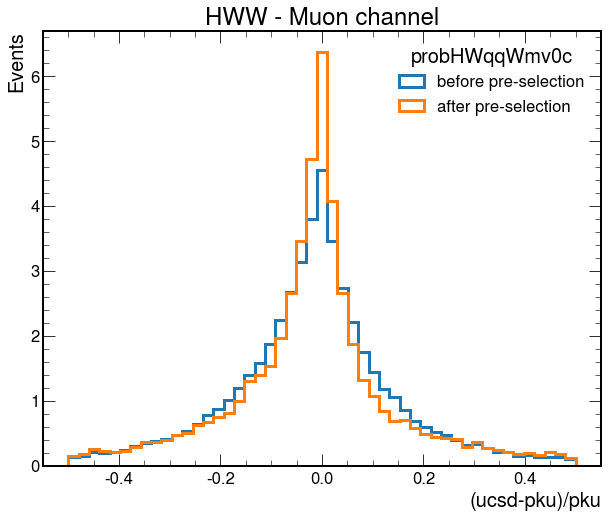

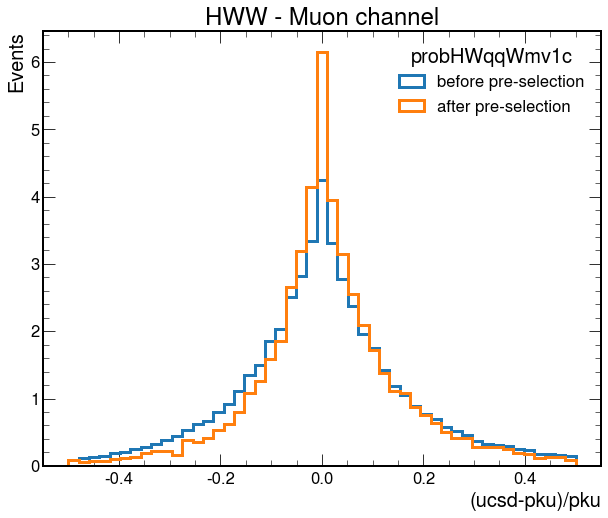

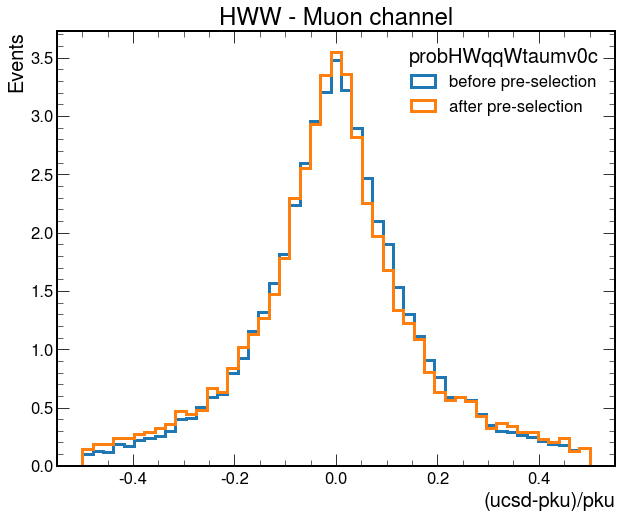

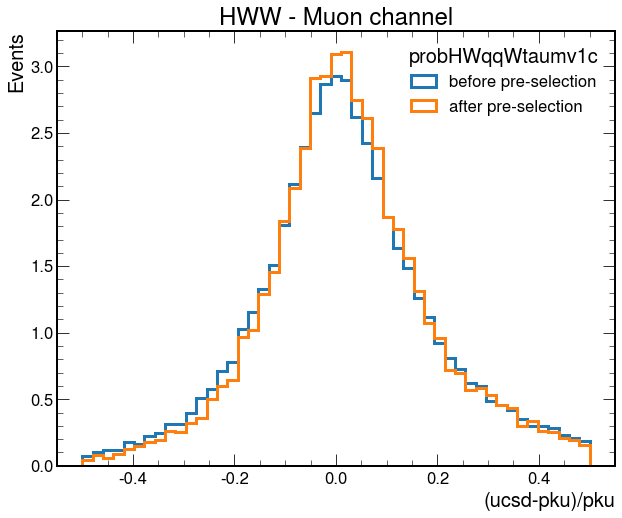

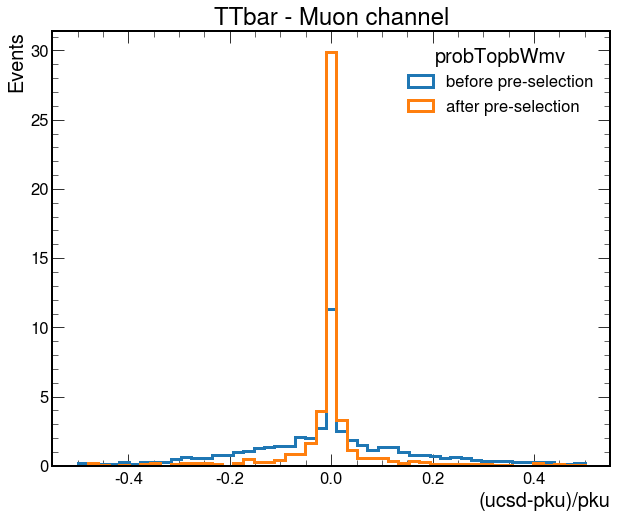

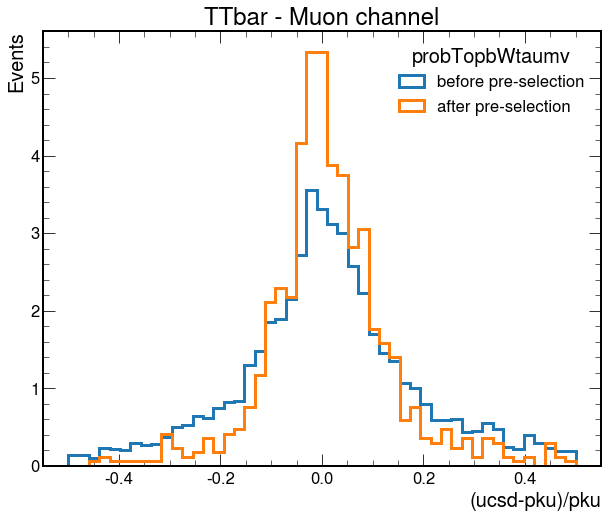

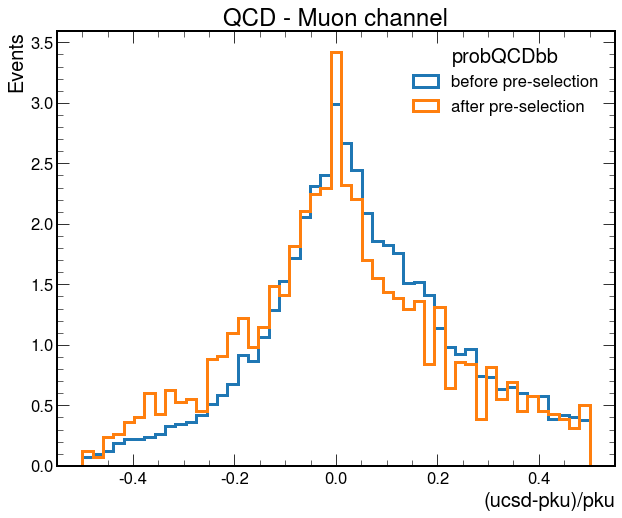

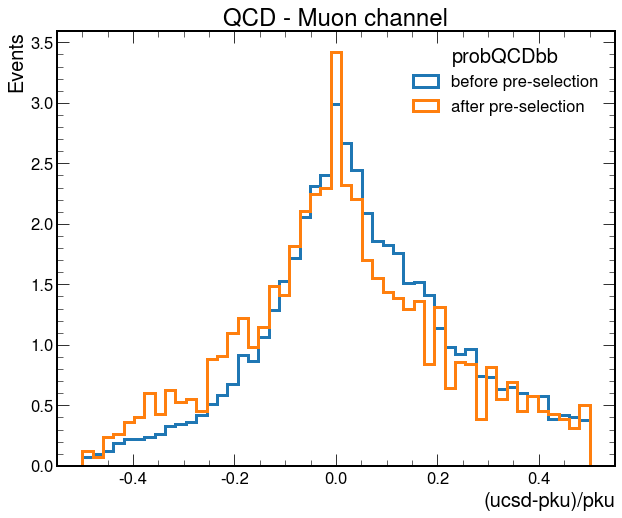

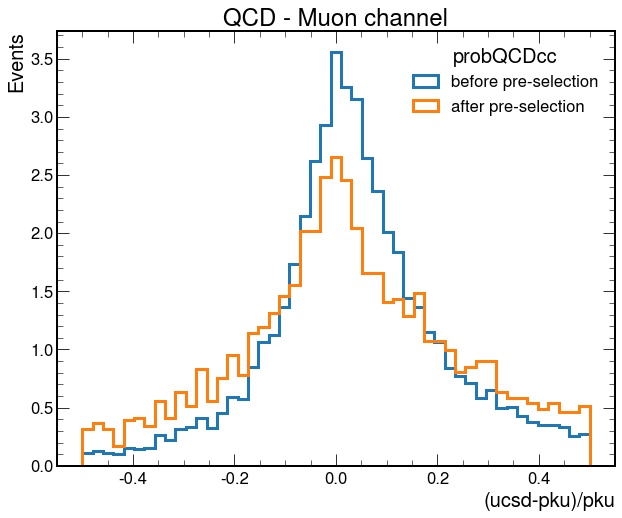

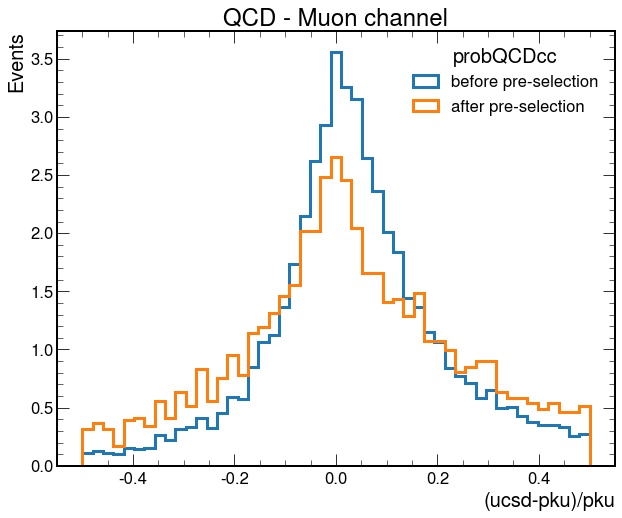

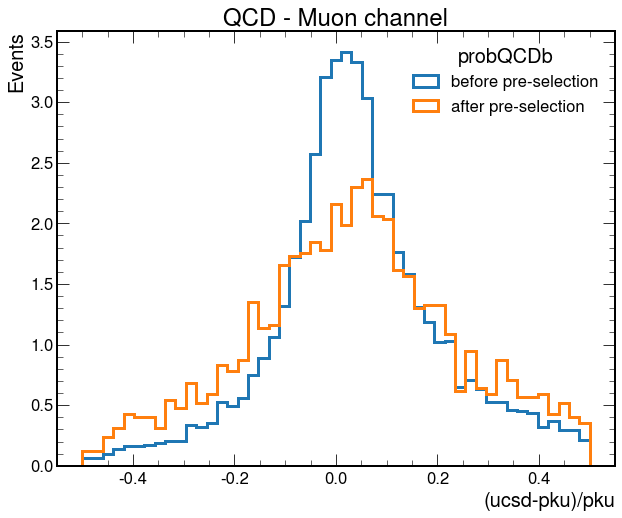

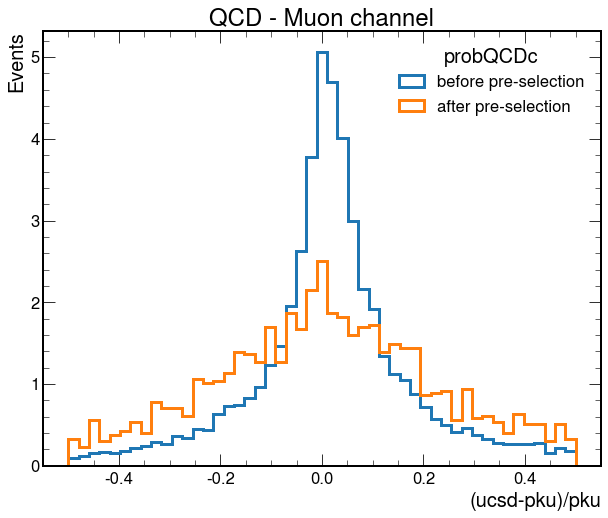

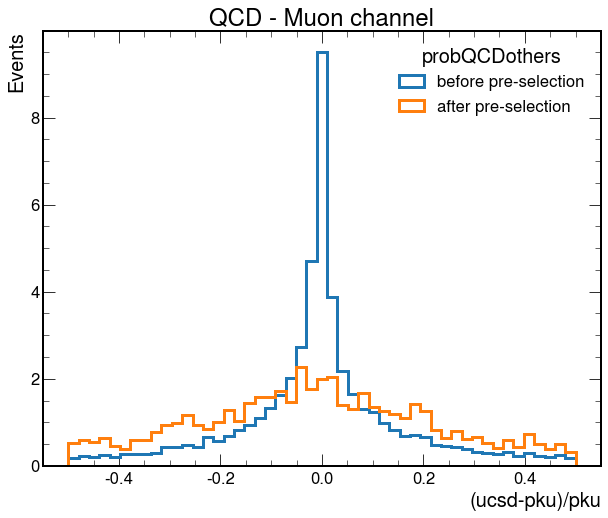

In [29]:
plt.rcParams.update({"font.size": 20})
samples_to_plot = ["HWW", "TTbar", "QCD"]

for ch in ["mu"]:#, "ele"]:
    if ch =="ele":
        test_ = "ev"
    else:
        test_ = "mv"
    
    for sample in samples_to_plot:

        for label_index, label in enumerate(UCSD_labels):
            
            for rel_label in relevant_labels[sample]:
                if rel_label in label:
                    
                    if (test_ in label) or (sample == "QCD"):
                        fig, ax = plt.subplots(figsize=(10, 8))

                        bins_ = np.linspace(-0.5,0.5,50)
                        
                        # plot resolution before preselection                        
                        ucsd_vals = events_dict_before_preselection[ch][sample][UCSD_labels[label_index]].values
                        pku_vals = events_dict_before_preselection[ch][sample][PKU_labels[label_index]].values

                        ax.hist(
                            (ucsd_vals-pku_vals)/pku_vals,
                            bins_,
                            label="before pre-selection",
                            linewidth=3,
                            density=True,
                            histtype="step"
                        )
                    
                        # plot resolution after preselection
                        ucsd_vals = events_dict_after_preselection[ch][sample][UCSD_labels[label_index]].values
                        pku_vals = events_dict_after_preselection[ch][sample][PKU_labels[label_index]].values
                        
                        ax.hist(
                            (ucsd_vals-pku_vals)/pku_vals,
                            bins_,
                            label="after pre-selection",
                            linewidth=3,
                            density=True,
                            histtype="step"
                        )
                                                
                        events_dict_before_preselection
                        
                        ax.set_title(f"{sample} - {xch} channel")
                        ax.legend(title=UCSD_labels[label_index][8:])
                        ax.set_ylabel("Events")
                        ax.set_xlabel("(ucsd-pku)/pku")
#                         ax.set_yscale("log");

# Make ROCs

In [98]:
presel = {
    "mu": {
        # normal preselection
        "leptonKin": "(lep_pt > 30)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",        
        
#         # iso/miso experiments        
#         "mini-iso": "(( (lep_pt < 55) & (lep_isolation < 0.15) ) | (lep_pt >= 55))",
#         "mini-iso": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
#         "iso": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    },
    "ele": {
        # normal preselection        
        "leptonKin": "(lep_pt > 40)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",
    }
}

In [272]:
labels = {
    
    # HWW
    "label_H_WqqWmv_0c": "( (fj_H_VV_munuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWmv_1c": "( (fj_H_VV_munuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtaumv_0c": "( (fj_H_VV_leptaumuvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtaumv_1c": "( (fj_H_VV_leptaumuvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    
    # others
    "label_H_WqqWqq_0c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==0) )",
    "label_H_WqqWqq_1c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==1) )",
    "label_H_WqqWqq_2c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==2) )",
    
    "label_H_WqqWq_0c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==0) )",
    "label_H_WqqWq_1c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==1) )",
    "label_H_WqqWq_2c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==2) )",
    
    "label_H_WW2lep": "(fj_lepinprongs==2)",
    "label_H_WW0lep": "(fj_lepinprongs==0)",
    
    "label_H_WqWev": "(fj_nprongs==1) & (fj_lepinprongs==1) & (fj_H_VV_elenuqq==1) ",
    "label_H_WqWmv": "(fj_nprongs==1) & (fj_lepinprongs==1) & (fj_H_VV_munuqq==1)",
    
    "label_H_WqqWev_0c": "( (fj_H_VV_elenuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWev_1c": "( (fj_H_VV_elenuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",

    "label_H_WqqWtauev_0c": "( (fj_H_VV_leptauelvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtauev_1c": "( (fj_H_VV_leptauelvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    

    "label_H_WqqWtauhv_0c": "( (fj_H_VV_hadtauvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtauhv_1c": "( (fj_H_VV_hadtauvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    
    # TTbar
    "label_Top_nob": "(fj_Top_bmerged==0)",
    
    "label_Top_bWqq_0c": "( (fj_Top_2q==1) & (fj_nprongs == 2)  & (fj_Top_bmerged==1) & (fj_ncquarks==0) )",
    "label_Top_bWqq_1c": "( (fj_Top_2q==1) & (fj_nprongs == 2) & (fj_Top_bmerged==1) & (fj_ncquarks==1) )",
    
    "label_Top_bWq_0c": "( (fj_Top_2q==1) & (fj_nprongs == 1) & (fj_Top_bmerged==1) & (fj_ncquarks==0) )",
    "label_Top_bWq_1c": "( (fj_Top_2q==1) & (fj_nprongs == 1) & (fj_Top_bmerged==1) & (fj_ncquarks==1) )",
    
    "label_Top_bWev": "( (fj_Top_bmerged==1) ) & (fj_Top_elenu==1)",
    "label_Top_bWmv": "( (fj_Top_bmerged==1) ) & (fj_Top_munu==1)",
    "label_Top_bWtauhv": "( (fj_Top_hadtauvqq==1) & (fj_Top_bmerged==1) )",
    
    "label_Top_bWtauev": "( (fj_Top_leptauelvnu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtaumv": "( (fj_Top_leptaumuvnu==1) & (fj_Top_bmerged==1) )",
}

match_labels = {
    "HWW": "fj_H_VV_isMatched",
    "TTbar": "fj_Top_isMatched",
}

# labels to check per sample
labels_per_sample = {
        "HWW": [
            "label_H_WqqWmv_0c","label_H_WqqWmv_1c",
            "label_H_WqqWtaumv_0c","label_H_WqqWtaumv_1c",        
        ], 
        "QCD": [],
}

def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den

In [196]:
cristina_labels = []
farouk_labels = []
fj_pt = []

labels_ = {}
for sample in samples:

    ### get a combined label to combine samples of the same process
    for key in combine_samples:
        if key in sample:
            sample_to_use = combine_samples[key]
            break
        else:
            sample_to_use = sample

    if sample_to_use not in ["HWW"]:
        continue

    print(f"Finding {sample} samples and should combine them under {sample_to_use}")

    out_files = f"{samples_dir}/{sample}/outfiles/"
    parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
    pkl_files = glob.glob(f"{out_files}/*.pkl")

    if not parquet_files:
        print(f"No parquet file for {sample}")
        continue                

    data = pd.read_parquet(parquet_files)
    not_empty = len(data) > 0

    # apply selection
    for selection in presel[ch]:
        data = data.query(presel[ch][selection])  

    # query labels from ucsd to match a pku label and save the column
    for label in labels:
        match_label = match_labels[sample_to_use]
        data[label] = data.query(labels[label])[match_label]            
    data.fillna(value=False,inplace=True)

    # get the labels
    label_farouk = [True] * len(data["fj_pt"].tolist())
#     label_cristina = (
#         data["label_H_WqqWmv_0c"] | 
#         data["label_H_WqqWmv_1c"] | 
#         data["label_H_WqqWtaumv_0c"] | 
#         data["label_H_WqqWtaumv_1c"]           
#     ).tolist()

    for lab in labels:
        labels_[lab] = data[lab]

#     cristina_labels += label_cristina
    farouk_labels += label_farouk    
    fj_pt += data["fj_pt"].tolist()

# cristina_labels = np.array(cristina_labels)
farouk_labels = np.array(farouk_labels)
fj_pt = np.array(fj_pt)    

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW


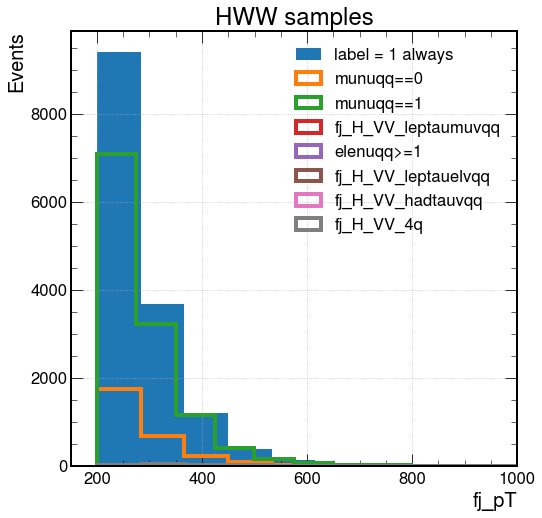

In [197]:
fig, ax = plt.subplots(figsize=(8,8))
ax.grid()
ax.hist(fj_pt[farouk_labels],
        linewidth=2,
        linestyle='solid',
        label="label = 1 always",
#         density=True        
       )
for lab in labels_:
    ax.hist(fj_pt[labels_[lab]],
            linewidth=4,
            linestyle='solid',
            label=lab,
            histtype="step"
    #         density=True
           )

ax.set_xlim(150, 1000)
ax.legend()
ax.set_xlabel("fj_pT")
ax.set_ylabel("Events")
ax.set_title("HWW samples");

IndexError: arrays used as indices must be of integer (or boolean) type

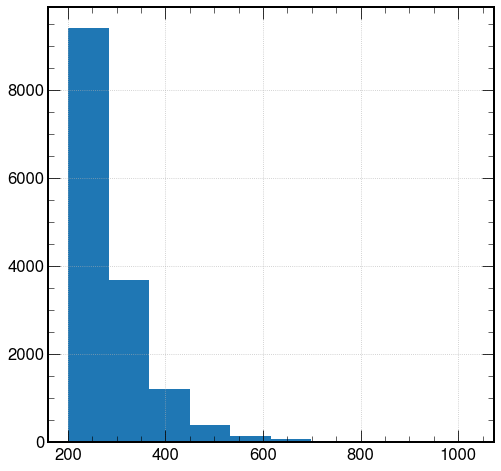

In [153]:
fig, ax = plt.subplots(figsize=(8,8))
ax.grid()
ax.hist(fj_pt[farouk_labels],
        linewidth=2,
        linestyle='solid',
        label="label = 1 always",
#         density=True        
       )
ax.hist(fj_pt[cristina_labels],
        linewidth=2,
        linestyle='solid',
        label="label = 1 by gen matching",
#         density=True
       )
ax.hist(fj_pt[~cristina_labels],
        linewidth=2,
        linestyle='solid',
        label="label ≠ 1 by gen matching",
#         density=True
       )
ax.legend()
ax.set_xlabel("fj_pT")
ax.set_ylabel("Events")
ax.set_title("HWW samples");

In [273]:
samples_to_process = ["HWW","QCD"]

hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtaumv1c"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]

roc_labels, roc_scores = {}, {}
PNs = ["ParT", "PKU_ParT"]
for pn_version in PNs:

    roc_labels[pn_version], roc_scores[pn_version] = [], []
    
    sigs = [s.replace("PN",pn_version) for s in hwwmv]
    bkgs = [s.replace("PN",pn_version) for s in qcd] 
    
    for sample in samples:
        
        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample
        
        if sample_to_use not in samples_to_process:
#             sample_to_use = "HWW"
            continue
    
        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                
                               
        data = pd.read_parquet(parquet_files)
        not_empty = len(data) > 0

        # apply selection
        for selection in presel[ch]:
            data = data.query(presel[ch][selection])  

        # query labels from ucsd to match a pku label and save the column
        for label in labels_per_sample[sample_to_use]:

            match_label = match_labels[sample_to_use]
            data[label] = data.query(labels[label])[match_label]            
        data.fillna(value=False,inplace=True)

        # fill NaN rows that didn't pass with False
                
        data["score"] = disc_score(data,sigs,bkgs)

        # get the scores        
        roc_scores[pn_version] += data["score"].tolist()                                
        
        # get the labels
        if "QCD" in sample_to_use:
            label = [0] * len(data["fj_pt"].tolist())
        elif "HWW" in sample_to_use:
#             label = [1] * len(data["fj_pt"].tolist())
            label = (
                data["label_H_WqqWmv_0c"] | 
                data["label_H_WqqWmv_1c"] | 
                data["label_H_WqqWtaumv_0c"] | 
                data["label_H_WqqWtaumv_1c"]           
            ).tolist()
        roc_labels[pn_version] += label

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
Finding QCD_Pt_1800to2400 samples and should combine them under QCD
Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
Finding QCD_Pt_1800to2400 samples and should combine them under QCD


Plotting score
  For ParT model


NameError: name 'roc_curve' is not defined

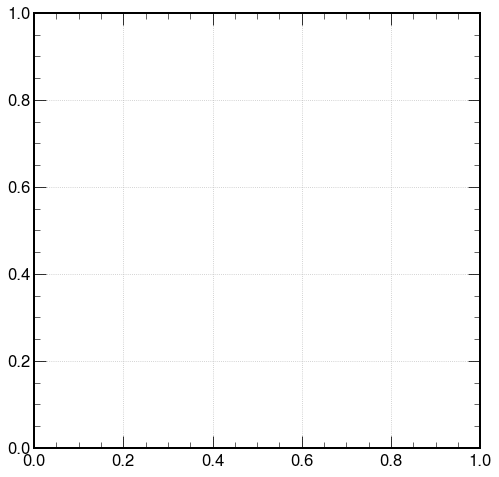

In [274]:
print(f"Plotting score")
fig, ax = plt.subplots(figsize=(8,8))
ax.grid()
for pn_version in PNs:
    print(f"  For {pn_version} model")

    labels_ = np.array(roc_labels[pn_version])
    scores_ = np.array(roc_scores[pn_version])

    is_nan = np.isnan(np.array(roc_scores[pn_version]))
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(scores_)}. Will remove them.")
        labels_ = labels_[~is_nan]
        scores_ = scores_[~is_nan]

    fpr, tpr, _ = roc_curve(labels_, scores_)
    ax.plot(tpr,fpr,linewidth=2,linestyle='solid',label=pn_version)
ax.set_xlim(0, 1)
ax.set_ylim(1e-4,1)
ax.set_xlabel(f'Signal efficiency (HWW)', fontsize=10, ha='right', x=1)
ax.set_ylabel(f'Mistag rate ', fontsize=10, ha='right', y=1)
ax.set_yscale('log')
xlab = r"$\frac{H_{WqqW(\ell\tau)\nu}}{H_{WqqW(e\tau)\nu}+QCD}$"
xch = "Muon"
ax.legend(title=f"{xch} Channel - {xlab}");
#     ax.set_title("new iso/miso")

# Old

In [324]:
labels = {
    "label_H_WqqWqq_0c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==0) )",
    "label_H_WqqWqq_1c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==1) )",
    "label_H_WqqWqq_2c": "( (fj_H_VV_4q==1) & (fj_nprongs==4) & (fj_ncquarks==2) )",
    "label_H_WqqWq_0c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==0) )",
    "label_H_WqqWq_1c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==1) )",
    "label_H_WqqWq_2c": "( (fj_H_VV_4q==1) & (fj_nprongs==3) & (fj_ncquarks==2) )",
    "label_H_WW2lep": "(fj_lepinprongs==2)",
    "label_H_WW0lep": "(fj_lepinprongs==0)",
    "label_H_WqWev": "(fj_H_VV_elenuqq==1) & (fj_nprongs==1) & (fj_lepinprongs==1)",
    "label_H_WqWmv": "(fj_H_VV_munuqq==1) & (fj_nprongs==1) & (fj_lepinprongs==1)",
    "label_H_WqqWev_0c": "( (fj_H_VV_elenuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWev_1c": "( (fj_H_VV_elenuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWmv_0c": "( (fj_H_VV_munuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWmv_1c": "( (fj_H_VV_munuqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtauev_0c": "( (fj_H_VV_leptauelvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtauev_1c": "( (fj_H_VV_leptauelvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtaumv_0c": "( (fj_H_VV_leptaumuvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtaumv_1c": "( (fj_H_VV_leptaumuvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    "label_H_WqqWtauhv_0c": "( (fj_H_VV_hadtauvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==0) )",
    "label_H_WqqWtauhv_1c": "( (fj_H_VV_hadtauvqq==1) & (fj_nprongs>=2) & (fj_ncquarks==1) )",
    
    "label_Top_nob": "(fj_Top_bmerged==0)",
    "label_Top_bWqq_0c": "( (fj_Top_2q==1) & (fj_nprongs == 2)  & (fj_Top_bmerged==1) & (fj_ncquarks==0) )",
    "label_Top_bWqq_1c": "( (fj_Top_2q==1) & (fj_nprongs == 2) & (fj_Top_bmerged==1) & (fj_ncquarks==1) )",
    "label_Top_bWq_0c": "( (fj_Top_2q==1) & (fj_nprongs == 1) & (fj_Top_bmerged==1) & (fj_ncquarks==0) )",
    "label_Top_bWq_1c": "( (fj_Top_2q==1) & (fj_nprongs == 1) & (fj_Top_bmerged==1) & (fj_ncquarks==1) )",
    "label_Top_bWev": "( (fj_Top_elenu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWmv": "( (fj_Top_munu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtauhv": "( (fj_Top_hadtauvqq==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtauev": "( (fj_Top_leptauelvnu==1) & (fj_Top_bmerged==1) )",
    "label_Top_bWtaumv": "( (fj_Top_leptaumuvnu==1) & (fj_Top_bmerged==1) )",
    
    "label_W_ev": "(fj_V_elenu==1) & (fj_lepinprongs==1)",
    "label_W_ev_0lep": "(fj_V_elenu==1) & (fj_lepinprongs==0)",
    "label_W_mv": "(fj_V_munu==1) & (fj_lepinprongs==1)",
    "label_W_mv_0lep": "(fj_V_munu==1) & (fj_lepinprongs==0)",
    "label_W_tauv": "(fj_V_taunu==1) & (fj_lepinprongs==1)",
    "label_W_tauv_0lep": "(fj_V_taunu==1) & (fj_lepinprongs==0)",
    "label_Z_2lep": "(fj_lepinprongs==2)",
    "label_Z_1lep": "(fj_lepinprongs==1)",
}

match_labels = {
    "HWW": "fj_H_VV_isMatched",
    "TTbar": "fj_Top_isMatched",
    "SingleTop": "fj_Top_isMatched",    
    "WJetsLNu": "fj_V_isMatched",
    "DYJets": "fj_V_isMatched",
}

In [325]:
# aesthetics
nicex_scores = {
    "hww_vs_qcd": r"$\frac{H_{WqqW(\ell\tau)\nu}}{H_{WqqW(e\tau)\nu}+QCD}$",
    "hww_vs_top": r"$\frac{H_{WqqW(\ell\tau)\nu}}{H_{WqqW(e\tau)\nu}+Top_{bW(\ell\tau\nu)}}$",
}

nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

import matplotlib.colors as mcolors
color_by_label = {}
for i,label in enumerate(labels):
    color_by_label[label] = list(mcolors.TABLEAU_COLORS.values())[i%10]

color_by_label["unmatched"] = "r"

In [326]:
# labels to check per sample
labels_per_sample = {
    "ele": {
        "TTbar": [
            "label_Top_bWev",
            "label_Top_bWtauev",
            "label_Top_nob",
        ],    
        "HWW": [
            "label_H_WqqWev_0c","label_H_WqqWev_1c",
        ],
        "QCD": [],
    },
    "mu": {
        "TTbar": [
            "label_Top_bWmv",
            "label_Top_bWtaumv",
            "label_Top_nob",
        ],      
        "HWW": [
            "label_H_WqqWmv_0c","label_H_WqqWmv_1c",
            "label_H_WqqWtaumv_0c","label_H_WqqWtaumv_1c",
        ], 
        "QCD": [],
        }
}

In [357]:
presel = {
    "mu": {
        # normal preselection
        "leptonKin": "(lep_pt > 30)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",        
        
#         # iso/miso experiments        
#         "mini-iso": "(( (lep_pt < 55) & (lep_isolation < 0.15) ) | (lep_pt >= 55))",
#         "mini-iso": "( (lep_pt < 55) |  ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
#         "iso": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    },
    "ele": {
        # normal preselection        
        "leptonKin": "(lep_pt > 40)",
        "fatjetKin": "(fj_pt > 200)",
        "ht": "(ht > 200)",
        "oneLepton": "(oneLepton)",
        "notaus": "(notaus)",
        "leptonInJet": "(leptonInJet)",
        "metfilters": "(metfilters)",
    }
}



presel = {
    "mu": {
        # normal preselection
        "leptonKin": "(lep_pt > 30)",
    },
    "ele": {
        # normal preselection        
        "leptonKin": "(lep_pt > 40)",
    }
}

In [361]:
# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c", "fj_PN_probHWqqWtaumv1c"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]
tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]


# first list is the numerator and second list is the denominator
scores = {
    "ele": {
        "hww_vs_qcd": [hwwev,qcd],
        "hww_vs_top": [hwwev,tope],
    },
    "mu": {
        "hww_vs_qcd": [hwwmv,qcd],
        "hww_vs_top": [hwwmv,topm],
    }
                     
}

def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den


roc_labels = {}
roc_scores = {}

PNs = ["ParT", "PKU_ParT"]
PNs = ["PN_v2"]

samples_dir = "../Feb15_2017"
for pn_version in PNs:
    pn_scores = {}
    roc_labels[pn_version] = {}
    roc_scores[pn_version] = {}
    for score,(sig,bkg) in scores[ch].items():
        new_sig = [s.replace("PN",pn_version) for s in sig]
        new_bkg = [s.replace("PN",pn_version) for s in bkg]
    
        pn_scores[score] = [new_sig,new_bkg]
        
        roc_labels[pn_version][score] = []
        roc_scores[pn_version][score] = []

    score_hists = {}
    for score in pn_scores.keys():
        score_hists[score] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 1, name="score", label=score)   
        )
        
    samples_to_process = ["HWW","QCD","TTbar"]#,"WJetsLNu"]
    samples = os.listdir(samples_dir)
    
    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample
        
        if sample_to_use not in samples_to_process:
            continue
    
        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                
                               
        data = pd.read_parquet(parquet_files)
        not_empty = len(data) > 0

        # apply selection
        for selection in presel[ch]:
            data = data.query(presel[ch][selection])  

        # query labels from ucsd to match a pku label and save the column
        for label in labels_per_sample[ch][sample_to_use]:
            match_label = match_labels[sample_to_use]
            data[label] = data.query(labels[label])[match_label]            

        # fill NaN rows that didn't pass with False
        data.fillna(value=False,inplace=True)
                
        for score,(sigs,bkgs) in pn_scores.items():
            data[score] = disc_score(data,sigs,bkgs)
            
            # make hist
            score_hists[score].fill(samples=sample_to_use,score=data[score])

            if score=="hww_vs_qcd" and sample_to_use in ["HWW","QCD"]:
                if "QCD" in sample_to_use:
                    label = [0] * len(data["fj_pt"].tolist())
                else:
                    label = (data["label_H_WqqWmv_0c"] | data["label_H_WqqWmv_1c"] | data["label_H_WqqWtaumv_0c"] | data["label_H_WqqWtaumv_1c"]).tolist()
                    
                    ### TODO: throw away if they not match
                    
                    label = [1] * len(data["fj_pt"].tolist())
                roc_scores[pn_version][score] += data[score].tolist()                                
                roc_labels[pn_version][score] += label
                
            elif score=="hww_vs_top" and sample_to_use in ["HWW","TTbar"]:
                if "TTbar" in sample_to_use:
                    label = (data["label_Top_bWmv"] | data["label_Top_bWtaumv"] | data["label_Top_nob"]).tolist()
                else:
                    label = (data["label_H_WqqWmv_0c"] | data["label_H_WqqWmv_1c"] | data["label_H_WqqWtaumv_0c"] | data["label_H_WqqWtaumv_1c"]).tolist()
                roc_scores[pn_version][score] += data[score].tolist()                                
                roc_labels[pn_version][score] += label

Finding TTToSemiLeptonic samples and should combine them under TTbar


KeyError: "None of [Index(['fj_PN_v2_probHWqqWmv0c', 'fj_PN_v2_probHWqqWmv1c',\n       'fj_PN_v2_probHWqqWtauev0c', 'fj_PN_v2_probHWqqWtaumv1c'],\n      dtype='object')] are in the [columns]"

In [360]:
for key in data.keys():
    print(key)

met
ht
nfj
nj
deta
mjj
fj_Top_isMatched
fj_nprongs
fj_lepinprongs
fj_ncquarks
fj_Top_bmerged
fj_Top_2q
fj_Top_elenu
fj_Top_munu
fj_Top_hadtauvqq
fj_Top_leptauelvnu
fj_Top_leptaumuvnu
weight
weight_genweight
weight_L1Prefiring
weight_pileup
mu_mvaId
mu_highPtId
weight_trigger_iso_muon
weight_trigger_noniso_muon
weight_isolation_muon
weight_id_muon
weight_mu
fj_pt
fj_msoftdrop
fj_bjets_ophem
fj_bjets
lep_pt
lep_isolation
lep_misolation
lep_fj_m
lep_fj_dr
lep_met_mt
met_fj_dphi
rec_higgs_m
label_Top_bWmv
label_Top_bWtaumv
label_Top_nob


Plotting hww_vs_qcd score
  For ParT model
Found 11810 NaN scores out of 75964. Will remove them.
  For PKU_ParT model
Found 11810 NaN scores out of 75964. Will remove them.
Plotting hww_vs_top score
  For ParT model
Found 29168 NaN scores out of 85207. Will remove them.
  For PKU_ParT model
Found 29168 NaN scores out of 85207. Will remove them.


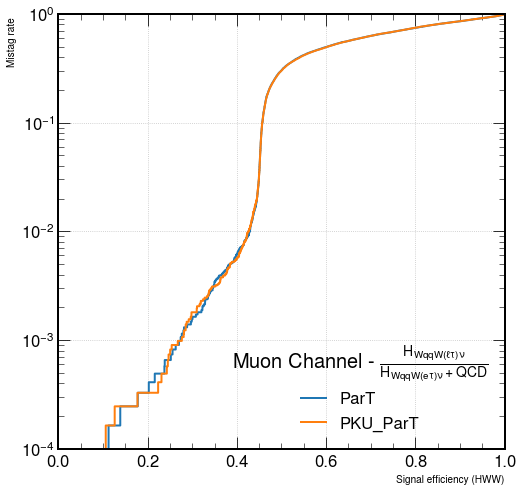

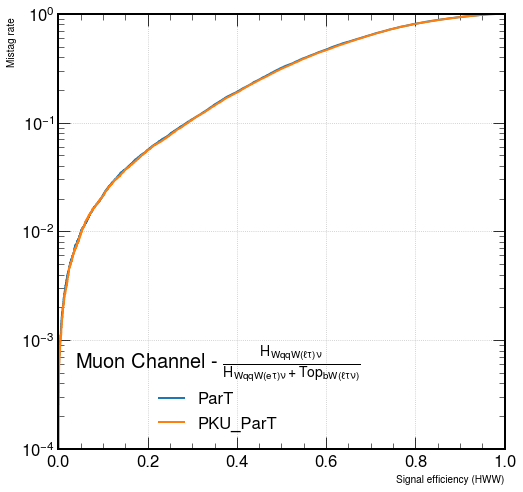

In [331]:
plt.rcParams.update({"font.size": 20})
for score in scores[ch].keys():
    print(f"Plotting {score} score")
    fig, ax = plt.subplots(figsize=(8,8))
    ax.grid()
    for pn_version in PNs:
        print(f"  For {pn_version} model")
        
        labels_ = np.array(roc_labels[pn_version][score])
        scores_ = np.array(roc_scores[pn_version][score])

        is_nan = np.isnan(np.array(roc_scores[pn_version][score]))
        if is_nan.sum()!=0:
            print(f"Found {is_nan.sum()} NaN scores out of {len(scores_)}. Will remove them.")
            labels_ = labels_[~is_nan]
            scores_ = scores_[~is_nan]
            
        fpr, tpr, _ = roc_curve(labels_, scores_)
        ax.plot(tpr,fpr,linewidth=2,linestyle='solid',label=pn_version)
    ax.set_xlim(0, 1)
    ax.set_ylim(1e-4,1)
    ax.set_xlabel(f'Signal efficiency (HWW)', fontsize=10, ha='right', x=1)
    #ax.set_ylabel(f'Mistag rate (QCD+WJetsLNu+TT)', fontsize=10, ha='right', y=1)
    ax.set_ylabel(f'Mistag rate ', fontsize=10, ha='right', y=1)
    ax.set_yscale('log')
    xlab = nicex_scores[score]
    xch = nice_channel[ch]
    ax.legend(title=f"{xch} Channel - {xlab}")
#     ax.set_title("new iso/miso")